# Fragmentation spectra embedding

In [1]:
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKeras

from functions import *

Using TensorFlow backend.


In [2]:
if is_notebook():
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline

Before filtering array (686, 719) vocab (719,)
266 mzs to remove
After filtering array (686, 453) vocab (453,)


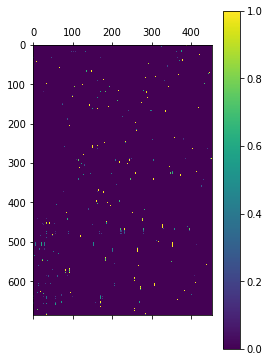

In [10]:
label = 'small'
data_path = '../data/representation_3/data_%s.txt' % label
data = load_data(data_path, num_samples=3000, remove_duplicate_spectra=True, filter_count=1)

spectra = data['spectra']
if is_notebook():
    plt.matshow(spectra)
    plt.colorbar()

In [11]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
                        verbose=1, epsilon=1e-5)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
callbacks = [rlr, early_stop]
if is_notebook():
    callbacks.append(PlotLossesKeras())

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [12]:
original_dim = spectra.shape[1]
latent_dim = 100
batch_size = 32
epochs = 200

In [13]:
autoencoder, encoder, decoder = get_simple_model(original_dim, latent_dim)
autoencoder.summary()
if is_notebook():
    plot_model_in_notebook(autoencoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 453)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               45400     
_________________________________________________________________
dense_4 (Dense)              (None, 453)               45753     
Total params: 91,153
Trainable params: 91,153
Non-trainable params: 0
_________________________________________________________________


In [14]:
pos = int(len(spectra) * 0.8)
spectra_train = spectra[0:pos, :]
spectra_test = spectra[pos:, :]

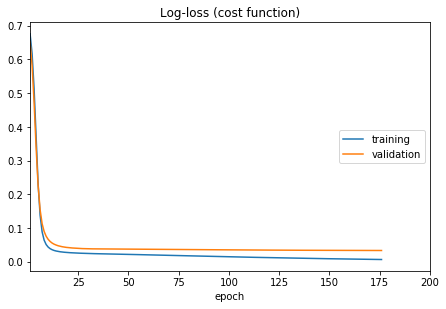

Epoch 00176: early stopping


In [15]:
autoencoder.fit(spectra_train, spectra_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(spectra_test, spectra_test),
                callbacks=callbacks)

[ 77.038  92.026 105.045 130.04  135.044]


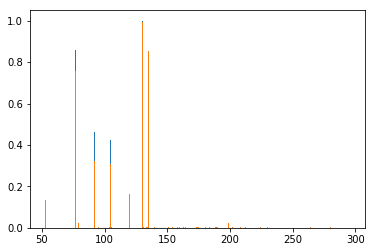

In [16]:
if is_notebook():
    spectra_encoded = encoder.predict(spectra_test)
    spectra_decoded = decoder.predict(spectra_encoded)
    for idx in range(1):
        pos = np.nonzero(spectra_test[idx])
        print(data['vocab'][pos])
        plt.bar(data['vocab'], spectra_test[idx])
        plt.bar(data['vocab'], spectra_decoded[idx])
        plt.show()

In [ ]:
autoencoder.save('../models/spectra_autoencoder_%s.h5' % label)
encoder.save('../models/spectra_encoder_%s.h5' % label)
decoder.save('../models/spectra_decoder_%s.h5' % label)